
## Máster Universitario en Ciencia de Datos
### Métodos Avanzados en Aprendizaje Automático


## Conjuntos de clasificadores
Este notebook muestrael funcionamiento básico de los conjuntos de clasificadores. Se muestras algunos ejemplos en problemas en 2D para su visualización y con problemas reales para ver sus capacidades y debilidades. Los temas que se tratan son:


* Proceso de combinación de clasificadores base en conjuntos y cómo se modifican las fronteras de decisión 
* Tiempos de entrenamiento y de clasificación en  conjuntos de clasificadores y ver cómo varía con respecto a la creación de un único árbol
* Errores de generalización de conjuntos de clasificadores en conjuntos de datos reales
* Importancia de las variables de entrenamiento en el modelo.

Hay cuestiones/ejercicios que se pueden contestar en este notebook directamente. En cualquier caso, la parte que hay que entregar de este notebook es *solo* la implementación de gradient boosting


In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import mode

#### Funciones auxiliares
Definición de conjuntos de datos en 2D para el análisis visual de las fronteras de decisión y cómo cambian con algunos parámetros. Funciones (inspiradas en sklearn) que usaremos a lo largo del notebook. 

La primera, *createDataSet*, es para crear los problemas, siempre de dos clases y en dos dimensiones. Sus argumentos son:

- *n*, número de patrones en el problema

- *model*, tipo de modelo para la frontera que separa las clases, puede ser 'linear', 'square' o 'sine'

- *ymargin*, margen de separación entre las dos clases, cuanto mayor es *ymargin* más separadas están las clases, valores negativos implican solape entre las clases

- *noise*, introduce un ruido gausiano a la x e y

- *output_boundary*, Si vale True la función devuelve la frontera de decisión

In [3]:
def createDataSet(n,model,ymargin,noise=None,output_boundary=False):
    x = np.random.rand(n,1)*2.0*np.pi
    xbnd = np.linspace(0,2.0*np.pi,100)

    if model == 'sine':
        y = (np.random.rand(n,1) - 0.5)*2.2
        c = y > np.sin(x)
        ybnd = np.sin(xbnd)
    elif model == 'linear':
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    elif model == 'square':
        y = np.random.rand(n,1)*4.0*np.pi*np.pi
        c = y > x*x
        ybnd = xbnd*xbnd
    else:
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    
    y[c == True] = y[c == True] + ymargin
    y[c == False] = y[c == False] - ymargin
    
    if noise is not None:
        y = y + noise * np.random.randn(n,1)
        x = x + noise * np.random.randn(n,1)

    if output_boundary == True:
        return x, y, (c*1).ravel(), xbnd, ybnd
    else:
        return x, y, (c*1).ravel()

La función *plotModel* la usaremos para dibujar el resultado de un clasificador sobre el conjunto de datos. Sus argumentos son:

- *x*, coordenada x de los puntos

- *y*, coordenada y de los puntos

- *c*, clase de los puntos, si se pasa None, entonces considera que x e y son la frontera real de decisión y la muestra con plot

- *clf*, el clasificador

- *title*, título para el gráfico

In [4]:
def plotModel(x,y,clase,clf,title=""):
    from matplotlib.colors import ListedColormap
    
    x_min, x_max = x.min() - .2, x.max() + .2
    y_min, y_max = y.min() - .2, y.max() + .2
    hx = (x_max - x_min)/100.
    hy = (y_max - y_min)/100.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    if hasattr(clf, "decision_function"):
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    elif hasattr(clf, "predict_proba"):
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    z = z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    plt.contourf(xx, yy, z, cmap=cm, alpha=.8)
    plt.contour(xx, yy, z, [0.5], linewidths=[2], colors=['k'])

    if clase is not None:
        plt.scatter(x[clase==0], y[clase==0], c='#FF0000')
        plt.scatter(x[clase==1], y[clase==1], c='#0000FF')
    else:
        plt.plot(x,y,'g', linewidth=3)
        
    plt.gca().set_xlim(xx.min(), xx.max())
    plt.gca().set_ylim(yy.min(), yy.max())
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

La función, *plotData*, la usaremos para dibujar los datos. Sus argumentos son:

- *x*, coordenada x de los puntos

- *y*, coordenada y de los puntos

- *c*, clase de los puntos

- *style0*, estilo con el que pintamos los puntos de la clase 0

- *style1*, estilo con el que pintamos los puntos de la clase 1

- *title*, título para el gráfico

In [5]:
def plotData(x,y,c,style0,style1,title=''):
    plt.scatter(x[c==0],y[c==0],**style0)
    plt.scatter(x[c==1],y[c==1],**style1)
    plt.grid(True)
    plt.axis([x.min()-0.2, x.max()+0.2, y.min()-0.2, y.max()+0.2])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

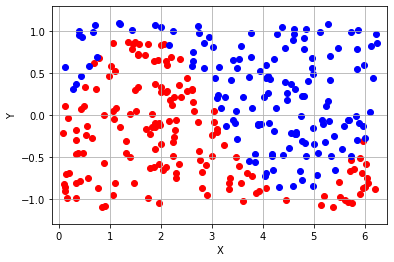

In [6]:
# Problem data:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.0             # <========= Modifica este valor 0 ó 0.3, (antes responde a las cuestiones de arriba)

x1, x2, ytrain, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
Xtrain = np.concatenate((x1, x2), axis = 1)

x1test, x2test, ytest      = createDataSet(n*10, model, ymargin, noise)
Xtest = np.concatenate((x1test, x2test), axis = 1)

plotData(x1,x2,ytrain,{'c':'#FF0000'},{'c':'#0000FF'})


### Teorema de Condorcet 

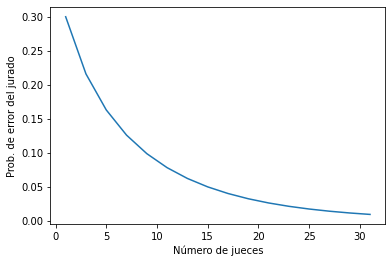

In [7]:
prob_error = 0.3  # <-- Modifica esta probabilidad para ver cómo evoluciona 
                  #     la probabilidad de equivocarse del jurado
num_jueces = 31   # Mejor que sea impar para evitar empates

p_error_jurado = np.zeros(num_jueces)
for i in range(1,num_jueces+1,2):
    mayoria = 1 + i//2
    p_error_jurado[i-1] = np.sum(sp.stats.binom.pmf(range(mayoria,i+1), i, prob_error))

# Puedes cambiar a semilogy para ver mejor cómo baja la prob de error
plt.plot(range(1,num_jueces+1,2),p_error_jurado[::2])

plt.ylabel('Prob. de error del jurado')
_ = plt.xlabel('Número de jueces')

# Algunas cuestiones:
#   * ¿Cuántos jueces necesitas para estar tener una prob del 99%
#      de que el jurado acierte con prob_error=0.3? ¿y con prob_error=0.1? 
#      ¿y con 0.45?
#   * ¿Qué sucede si la probabilidad de equivocarse de cada juez es >0.5?


### Muestras bootstrap y bagging
Una muestra bootstrap estándar consiste realizar N extracciones aleatorias con reemplazamiento de una urna con N elementos. Algunas variaciones incluyen:

* Realizar M extracciones con $M\neq N$
* Realizar las extracciones sin reemplazamiento

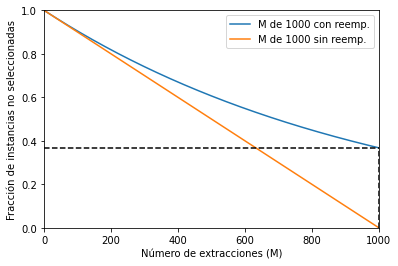

In [7]:
N = 1000                         # no de datos
MC  = np.array(range(1,N+201,1)) # no de extracciones con reemplazamiento
MS = np.array(range(1,N+1,1))    # no de extracciones sin reemplazamiento

plt.plot(MC, ((N-1)/N)**MC, label='M de {} con reemp.'.format(N))
plt.plot(MS, (N-MS)/N,      label='M de {} sin reemp.'.format(N))

plt.plot([0,N], [((N-1)/N)**N, ((N-1)/N)**N], 'k--')
plt.plot([N,N], [0,            ((N-1)/N)**N], 'k--')

plt.xlim([0,MS[-1]])
plt.ylim([0,1])

plt.ylabel('Fracción de instancias no seleccionadas')
plt.xlabel('Número de extracciones (M)')

_=plt.legend()



### Algoritmo bagging
Esqueleto del algoritmo bagging. Rellena las partes que falta para que funcione

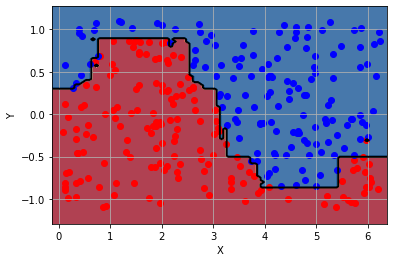

In [15]:
from sklearn.tree import DecisionTreeClassifier

class BaggingCasero:
    def __init__(self, n_estimators=101):
        self.n_estimators = n_estimators
        self._estimators = []
    
    def fit(self,X,y):
        N = X.shape[0]
        for i in range(self.n_estimators):
            """
              Rellenar esta parte para que cree un árbol usando
              una muestra bootstrap de los datos
            """
            indices = np.random.choice(N, size=N, replace=True)
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]
            tree=DecisionTreeClassifier()
            tree.fit(X_bootstrap, y_bootstrap)
            self._estimators.append(tree)

            
    def predict(self,X):
        votos = np.zeros((X.shape[0],len(self._estimators)))
        # Calcula la salida de cada árbol para cada dato
        for ie,estimator in enumerate(self._estimators):
            votos[:,ie] = estimator.predict(X)
            
        """
           Calcula la clase más votada de cada ejemplo, es decir,
           la moda
        """
        moda, _ = mode(votos, axis=1)
        return moda
            
        
            
bagging = BaggingCasero()

bagging.fit(Xtrain, ytrain)

plotModel(x1,x2,ytrain,bagging)

In [8]:
from sklearn.tree import DecisionTreeClassifier

### Algoritmo gradient boosting (parte 2 de la práctica)
Algoritmo de gradient boosting para implementar. Solo hay que incluir el código en las partes indicadas. Se implementará el algoritmo para regresión y para clasificación

In [9]:
from sklearn.tree import DecisionTreeRegressor

""" Solo se va a implementar para regresión y para clasificación 
    binaria con clases igual a -1 y +1
"""

class SquaredErrorLoss:
    """ Clase que define elementos para la función cuadrática de perdida 
        para regresión """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la salida 'y' """
        return np.mean(y)

    def residuos(_, y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """
        return y - F

    def paso_newton_hoja(_, y, residuos, valor):
        """ Función para actualizar la salida de una hoja el árbol
        
           Recibe información sobre los ejemplos de una hoja dada. En concreto
           para los ejemplos que caen en una hoja:
              * El vector de valores a predecir (y)
              * Los pseudo-residuos (residuos) sobre los que se ha
                entrenado alarbol regresor ht
           Además recine el valor actual de salida de la hoja
              
            Debe devolver el valor actualizado
        """
        return valor
    
    def __call__(self, y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """
        return 0.5*(y-F)**2
    
class LogLoss:
    """ Clase que define elementos para la función logística de perdida 
        para clasificación de dos clases {-1, +1} """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la salida 'y' """
        return 0.5 * np.log((1.0 + ybar) / (1.0 - ybar))

    def residuos(_, y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """
        return (2.0 * y) / (1 + np.exp(2.0 * y * F))

    def paso_newton_hoja(_, y, residuos, valor):
        """ Función para actualizar la salida de una hoja el árbol
        
           Recibe información sobre los ejemplos de una hoja dada. En concreto
           para los ejemplos que caen en una hoja:
              * El vector de valores a predecir (y)
              * Los pseudo-residuos (residuos) sobre los que se ha
                entrenado alarbol regresor ht
           Además recine el valor actual de salida de la hoja
              
            Debe devolver el valor actualizado
        """
        residuos_abs = np.abs(residuos)
        try:
            return np.sum(residuos)/np.sum(residuos_abs*(2.0-residuos_abs))
        except ZeroDivisionError:
            return 0.0
    
    def predict(_, y):
        return 2*((1.0/(1.0 + np.exp(-2 * y))) >= 0.5) - 1
    
    def __call__(self,y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """
        return np.log(1+np.exp(-2.0*y*F))
     
class GBCasero:
    def __init__(self, n_estimators=101, loss=SquaredErrorLoss(), eta=0.1, depth=3):
        self.n_estimators = n_estimators
        self._estimators  = []
        self.depth        = depth
        self.eta          = eta
        # La implementación de loss se usará en fit para crear el algoritmo
        # GB de forma genérica.
        self.loss         = loss
    
    def fit(self,X,y):
        """
          Inicializa GB 
        """
        for i in range(self.n_estimators):
            tree = DecisionTreeRegressor(max_depth = self.depth)
            """
              Rellenar esta parte para implementar GB 
              Se debe utilizar la función paso_newton de abajo
            """
            residuos = self.loss.residuos(y, self.predict(X))
            tree = tree.fit(X, residuos)
            self.paso_newton_general(tree, X, y, residuos)
            self._estimators.append(tree)
            
    def predict(self,X):
        """ Combinamos los valores de pesos y hs para obtener la 'salida' o
             predicciones en crudo, y que haga:
               * Para regresión se devuelve 'salida'
               * Para clasificación de 2 clases se calcula la probabilidad
                  con una sigmoidal (1 / (1 + np.exp(-2*salida))) y se 
                  devuelve la clase más probable 
                  
            Nota1: Podéis delegar esto a las funciones de pérdida para evitar 
                   poner aquí in if
            Nota2: Podéis también organizar la clasificacion/regresion al estilo
                   sklearn e implementar predict_proba en la clasificación.
                
        """
        
        salida = sum(i.predict(X)*self.eta for i in self._estimators)
        return self.loss.predict(salida)

    def paso_newton_general(self, tree, X, y, residuos):
        """ Esta función actualiza todas las hojas de salida
            del árbol 'tree' utilizado la función paso_newton_hoja
            de las clases de funcion de pérdida """
        TREE_LEAF = -1
        tree = tree.tree_
        leaf_indices = tree.apply(np.array(X,dtype=np.float32))
        for leaf in np.where(tree.children_left == TREE_LEAF)[0]:
            ii = leaf_indices==leaf
            tree.value[leaf,0,0] = self.loss.paso_newton_hoja(y[ii],
                                                              residuos[ii],
                                                              tree.value[leaf,0,0])


Accuracy in Magic04= 0.8503548895899053


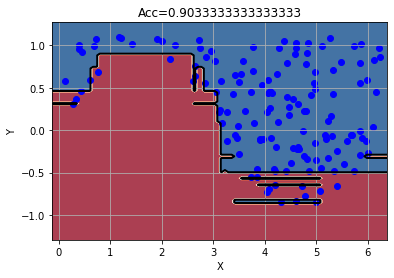

In [10]:
from sklearn.preprocessing import LabelBinarizer

# Basic example
gb = GBCasero(loss=LogLoss())

lb     = LabelBinarizer(pos_label = 1, neg_label = -1)
ytrain = lb.fit_transform(ytrain).ravel()
ytest  = lb.transform(ytest).ravel()

gb.fit(Xtrain, ytrain)
acc = np.sum(gb.predict(Xtest)==ytest)/len(ytest)
plotModel(x1,x2,ytrain,gb,"Acc="+str(acc))

# Magic
fP = 'magic04.csv'
dfP = pd.read_csv(fP, sep=',')

X_tr, X_ts, y_tr, y_ts = train_test_split(dfP.values[:,:-1], dfP.values[:,-1], 
                                          test_size=0.8, random_state=1)
lb   = LabelBinarizer(pos_label = 1, neg_label = -1)
y_tr = lb.fit_transform(y_tr).ravel()
y_ts = lb.transform(y_ts).ravel()

gb = GBCasero(loss=LogLoss())

gb.fit(X_tr, y_tr)
print("Accuracy in Magic04=",np.sum(gb.predict(X_ts)==y_ts)/len(y_ts))

# Incluir aquí pruebas para regresión con la pérdida cuadrática


### Visualizar fronteras de clasificación
Se entrena un random forest con 3 árboles para visualizar la frontera de decisión cuándo se combinan en el conjunto de clasificadores y cada árbol por separado
<div style="background-color:#AAEEAA;padding:20px;border:solid;">Ejecuta el código de con noise=0 y n_estimators=3 y estudia el resultado de los árboles por separado y en conjunto. En concreto analiza:
<ul>
<li> (1) Las fronteras de decisión de los árboles individuales con respecto a la frontera de los árboles combinados.</li>
<li> (2) ¿Por qué son tan diferentes las fronteras de los árboles individuales? Para responder piensa cómo se han creado esos árboles</li>
<li> (3) Mira los errores en test de los árboles individuales y del conjunto ¿Cuál es que mejor error obtine? ¿Por qué?</li>
</ul>
</div>
</div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">Respuestas:
    <b>Nota: No es necesario entregar ninguna de estas cuestiones</b> 
<ul>
<li> (1) ...</li>
<li> (2) ...</li>
<li> (3) ...</li>
</ul>
</div>

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Ahora ejecuta las dos celdas siguientes modificando el nivel de ruiso (noise=0.0 y noise=0.3). A continuación prueba con n_estimators igual a 3, 31 y 301 para cada uno de los niveles de ruido y rellena el acierto en test y train en la siguiente tabla:<br/></div>
<br>

<div style="background-color:#EEEEAA;padding:20px;border:solid;">

(4) Respuestas:

| Acierto train/test | n_estimators=3 | n_estimators=31 | n_estimators=301 |
|--------------------|----------------|-----------------|------------------|
| noise=0            |                |                 |                  |
| noise=0,3          |                |                 |                  | 

</div>

Score train = 0.993333
Score test = 0.944667
Score test tres primeros árboles = 0.459667,0.460000,0.420333


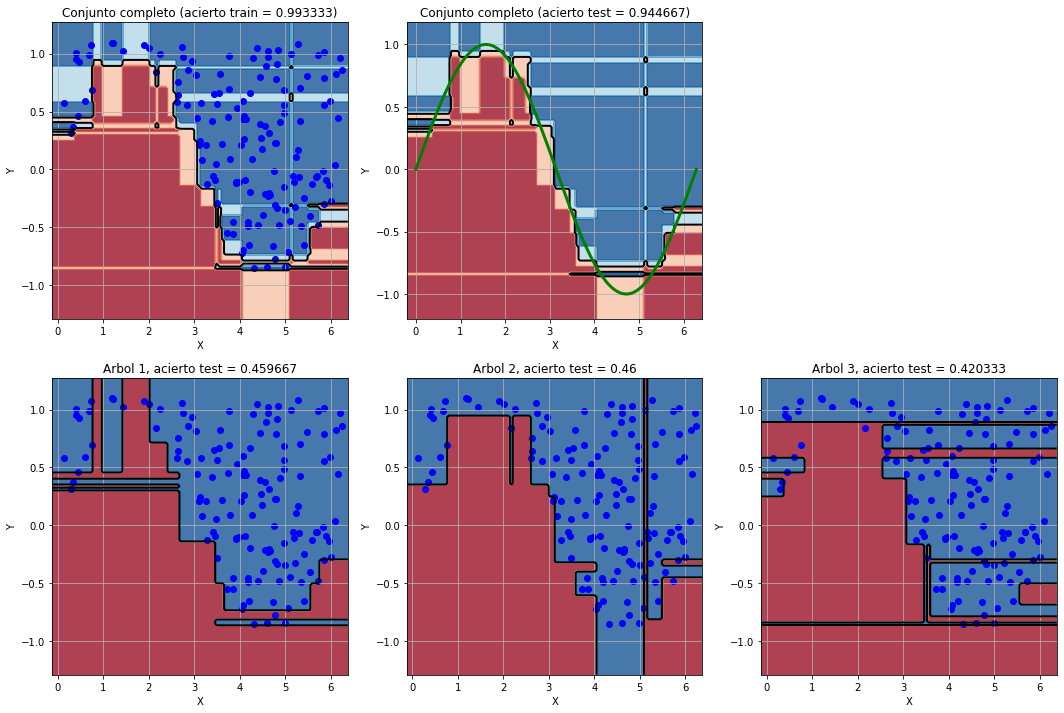

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Construcción del clasificador:
np.random.seed(11)
clf = RandomForestClassifier(n_estimators=3) # <= Modif este valor 3, 31 y 301(antes responde a las cuestiones de arriba)
clf.fit(Xtrain, ytrain)

# Calculo del acierto en los conjuntos de entrenamiento y test:
score_train = clf.score(Xtrain, ytrain)
print("Score train = %f" % (score_train))
score_test = clf.score(Xtest, ytest)
print("Score test = %f" % (score_test))

scores_single_trees_test = [dt.score(Xtest, ytest) for dt in clf.estimators_[0:3]]

print("Score test tres primeros árboles = %f,%f,%f" % tuple(scores_single_trees_test))

# Gráficas:
plt.figure(figsize=(18,12))

plt.subplot(231)
t = "Conjunto completo (acierto train = {:g})".format(score_train)
plotModel(x1,x2,ytrain,clf,t)

plt.subplot(232)
t = "Conjunto completo (acierto test = {:g})".format(score_test)
plotModel(xbnd,ybnd,None,clf,t)

# Se muestra el acierto y frontera de los 3 primeros árboles
# del conjunto
for i in [1,2,3]:
    plt.subplot(2,3,3+i)
    t = "Arbol {}, acierto test = {:g}".format(i,scores_single_trees_test[i-1])
    plotModel(x1,x2,ytrain,clf.estimators_[i-1],t)



<div style="background-color:#AAEEAA;padding:20px;border:solid;">A continuación se realiza el cálculo el acierto del conjunto con en train y en test con respecto al número de clasificadores combinados. Puedes utilizar la función suministrada individualPredictions, que dado un conjunto de datos y otro de clasificadores devuelve las clasificaciones de cada clasificador base para cada ejemplo
</div>

In [12]:
# individualPredictions: Devuelve la predicción para cada dato por parte de cada clasificador 
#                        de un conjunto de clasificadores
#     Entrada:
#         - ens: lista con un conjunto de clasificadores
#         - X  : ejemplos a clasificar
#     Salida:
#         - Matriz de predicciones de número de ejemplo filas y no. clasificadores columnas
def individualPredictions(ens, X):
    P = np.ones((X.shape[0],len(ens)))
    it = 0
    for dt in ens:
        P[:,it] = dt.predict(X)
        it += 1

    return P



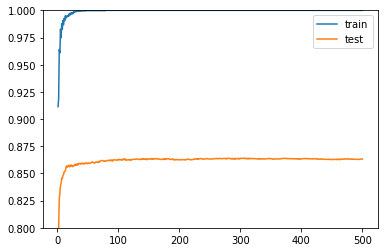

In [13]:
from sklearn.model_selection import train_test_split
import pandas as pd

def accuracy(ens, pr, y):
    pr = np.cumsum(pr,axis=1)/np.arange(1.,pr.shape[1]+1,1.)
    pr[pr>0.5] = 1
    pr[pr<=0.5] = 0

    iclases_test = np.zeros(np.array([y]).T.shape)
    iclases_test[y==ens.classes_[0]] = 0
    iclases_test[y==ens.classes_[1]] = 1

    Pok = pr==iclases_test
    return np.array(Pok.sum(axis=0),dtype=float)/len(y)

    
# Cargamos datos
fP = 'magic04.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

#separación training-test
X_train, X_test, clases_train, clases_test = train_test_split(dfP.values[:,:-1], dfP.values[:,-1], test_size=0.8, random_state=1)

n_trees = 500
clf = RandomForestClassifier(n_estimators=n_trees)
clf.fit(X_train, clases_train)

P = individualPredictions(clf.estimators_, X_train)
accu_tr = accuracy(clf,P,clases_train)

P = individualPredictions(clf.estimators_, X_test)
accu_ts = accuracy(clf,P,clases_test)

plt.plot(range(1,n_trees+1),accu_tr,label="train")
plt.plot(range(1,n_trees+1),accu_ts,label="test")
plt.ylim([0.8,1])
_ = plt.legend()


<div style="background-color:#AAEEAA;padding:20px;border:solid;">Usando la tabla y la gráfica describe cómo evoluciona el error en en entrenemiento y test con respecto al número de árboles que se combinan en el conjunto ¿Se observa sobre ajuste al aumentar el número de clasificadores? Es decir, ¿sube el error en test a partir de algún umbral del número de clasificadores?<br/></div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">(5) Respuesta: 
</div>

### Tiempos de entrenamiento y test de los árboles de decisión
Vamos a medir tiempos de entrenamiento y clasificación de árboles de decisión y a compararlos con los tiempos de las SVMs. Probaremos a entrenar los modelos con 300 datos y con 600


In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as skpp
import timeit
from sklearn.svm import SVC

n_executions = 1

# Cargamos datos
fP = 'pimaND.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

# Dividimos train/test
n_train = 600                                      # <================== Modificar 300 o 600
perm = np.random.permutation(dfP.shape[0])
indices_train = perm[0:n_train]
indices_test  = perm[n_train:]

    
clf = SVC(C=10.0, kernel='linear', degree=1.0, coef0=1.0, gamma=0.1) # <================== Modificar DT o SVM
#clf = DecisionTreeClassifier()
#clf = RandomForestClassifier(n_estimators=100)  # <================== Modificar 100 o 1000

# Tiempo de entrenamiento
tic = timeit.default_timer()
for ie in range(n_executions):    # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    clf.fit(dfP.values[indices_train,:-1],dfP.values[indices_train,-1])
toc = timeit.default_timer()

print("Tiempo de entrenamiento con {} ejemplos: {:.4g} s.".format(len(indices_train),(toc - tic)/n_executions))

n_executions = 10

# Tiempo de clasificacion
tic = timeit.default_timer()
for ie in range(n_executions):   # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    _ = clf.predict(dfP.values[indices_test,:-1])
toc = timeit.default_timer()

factor = 600.
print("Tiempo de clasificar {:g} ejemplos: {:.4g} s.".format(factor, factor*(toc - tic)/n_executions/len(indices_test)))

Tiempo de entrenamiento con 600 ejemplos: 24.72 s.
Tiempo de clasificar 600 ejemplos: 0.005202 s.


<div style="background-color:#AAEEAA;padding:20px;border:solid;">Se debe ejecutar la celda de arriba utilizando conjuntos de clasificadores con 100 y 1000 árboles. Hazlo usando 300 datos de entrenamiento y 600. A continuación se debe rellenar los tiempos en la siguiente tabla comparando con lo obtenido en con árboles y SVC:<br/></div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">(6) Respuestas:

|  Tiempos (s)          | Árbol  | SVC  | RF100 | RF 1000 |
|-----------------------|--------|------|-------|---------|
| Entrenamiento con 300 |  0.003052 s.   | 13.43 s.  | 0.3713 s.  | 2.319 s.    |
| Entrenamiento con 600 | 0.006215 s.    | 24.72 s. | 0.1947 s.  |  2.482 s.   |
| Clasificación con modelo entr. con 300 (10^6 ejemplos) | 0.0004664 s.    |  0.001279 s.  | 0.02587 s.  |  0.1015 s.   |
| Clasificación con modelo entr. con 600 (10^6 ejemplos) |  0.001273 s.  | 0.005202 s. | 0.05045 s.  | 0.4911 s.    |

(+) Recuperar datos de la práctica anterior

(++) Rellenar estos datos ejecutando el código de arriba
</div>
<br/>

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Usando la tabla comenta los resultados.<br/>

<ul>
<li>(7) ¿Cómo varían los tiempos de entrenamiento al doblar el número de datos de entrenamiento? ¿Y los tiempos de clasificación?</li>
<li>(8): Explica los resultados y comparalos con los de un solo árbol</li>
</ul>
</div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">Respuesta:

<ul>
<li>(7): </li>
<li>(8): </li>
</ul></div>

### Comparativa
Vamos a comparar los resultados de clasificación de algunos conjuntos de clasificadores y árboles de decisión.

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Completa el código de abajo para comparar un árbol de decisión y los conjuntos bagging, adaboost y random forest. Se debe obtener el acierto para los conjuntos de datos: pimaND, spamND, magic04 y sonar. Esto se hará usando validación cruzada de 10 hojas.<br/>
</div>

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


# Lista con los ficheros de datos
dataset_names = ['spamND.csv', 'magic04.csv' ,'sonar.csv' ,'pimaND.csv']
# Cargo un conjunto de datos
idata=1
d = pd.read_csv(dataset_names[idata], sep=',')
print(dataset_names[idata])

# Creamos las particiones en entrenamiento y test para probar los distintos modelos
# Es importente que la partición sea igual para todos los modelos de forma que los 
# errores sean comparables. Eso se puede lograr fijando el random_state
indexFolds = KFold(n_splits=10, shuffle=True, random_state=11)

# Para conjuntos grades (pe. magic) puede que hacer entrenamiento con el 90% de los datos (como
#   sucede con KFold usando n_folds=10) sea inviable. Si tarde damasiado puedes usar la siguiente línea
#   para magic y tal vez para spamND
#indexFolds = cross_validation.ShuffleSplit(250, n_iter=10, test_size=0.8, random_state=0)

# Lista con los modelos a probar
n_trees = 250
modelos = [DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=n_trees),
          AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=10), 
                             n_estimators=n_trees),
          BaggingClassifier(n_estimators=n_trees)]
names= ['DecisionTree', 'RandomForest', 'AdaBoost    ', 'Bagging     ']

# Bucle para recorrer cada modelo a probar
for n,clf in zip(names, modelos):
    errors = []
    # Recorremos las particiones
    for idxTr, idxTs in indexFolds.split(d):
        # Train model
        clf.fit(d.values[idxTr,:-1],d.values[idxTr,-1])
        # Validate model
        score = clf.score(d.values[idxTs,:-1],d.values[idxTs,-1])
        errors.append(1.0 - score)

    errors = np.array(errors)
    print("{}: {:0.3g}%%".format(n,100*errors.mean()) + " +- {:.3g}".format(100*errors.std()))


magic04.csv
DecisionTree: 18.2%% +- 0.705
RandomForest: 11.8%% +- 0.715
AdaBoost    : 12.2%% +- 0.869
Bagging     : 12.2%% +- 0.758


<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;"> Resultados:

|  Error de test (%) $\pm$ desv      | Árbol  | RandomForest  | AdaBoost | Bagging |
|-----------------------|--------|------|-------|---------|
| Pima  | 32.8%% +- 5.59    | 23.7%% +- 4.09  | 27.1%% +- 6.14  |  24.6%% +- 5.88  |
| Spam  | 43.9%% +- 3.63   | 37.7%% +- 3.33  |  41.6%% +- 2.81 | 38.1%% +- 3.19 |
| Sonar |  26.4%% +- 7.11  | 16.9%% +- 7.03  | 14.4%% +- 6.03  |  18.3%% +- 7.36  |
| Magic | 18.2%% +- 0.705  | 11.8%% +- 0.715 | 12.2%% +- 0.869  | 12.2%% +- 0.758  |

(+) Rellenar estos datos ejecutando el código implementado. Dar el error y la desviación estándar. Por ejemplo $15.0 \pm 3.4$
</div>
<br>
<div style="background-color:#AAEEAA;padding:20px;border:solid;">
Comenta los resultados:

</div>
<br/>


### Atributos más importantes
Vamos a ver cuáles son los atributos más importantes de los conjuntos de datos analizados arriba. Al entrenar el conjunto se guarda en la variable feature\_importances\_ la importancia relativa de cada variable medida en función de cómo de alto aparece en cada árbol.

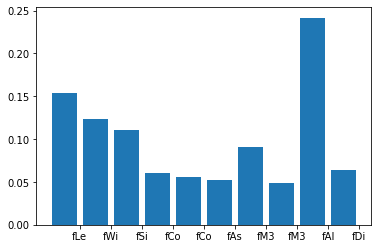

In [49]:
from sklearn.model_selection import train_test_split

# Cargamos datos
fP = 'magic04.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

#
#separación training-test
X_train, X_test, clases_train, clases_test = train_test_split(dfP.values[:,:-1], dfP.values[:,-1], test_size=0.3, random_state=1)

# Lista con los modelos a probar
n_trees = 301
clf= RandomForestClassifier(n_estimators=n_trees)

# Entrenamos
clf.fit(X_train,clases_train)

# Mostramos los atributos más relevantes
_ = plt.bar(np.arange(1,dfP.values.shape[1]), clf.feature_importances_)
_ = plt.xticks(np.arange(1,dfP.values.shape[1])+0.5, [lab[0:3] for lab in lVarsTarg[:-1]])

<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;"> Indica las dos variables más importante para cada conjunto de datos:

|  Error de test (%) $\pm$ desv      | Nombre Variable 1 | Nombre Variable 2 |
|-----------------------|--------|------|
| Pima  | glu    | 0.24  |
| Spam  | capital_run_length_total | 0.08 |
| Sonar |  a11   | 0.07  |
| Magic | fAl    | 0.24  |

(+) Rellenar estos datos 
</div>
<br>
<div style="background-color:#AAEEAA;padding:20px;border:solid;">
Comenta los resultados:

</div>
<br/>
